# Autoregressive Model Testing (SARIMA & SARIMAX)

In [363]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML

In [364]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

## Data Preparation

In [365]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC', 'CC Monthly % Change', 'VIX', 'MOVE', 'PC1_macro', 'PC2_macro']
vol_macro_list = ['vol_LFPR', 'vol_CPI', 'vol_r', 'vol_M1', 'vol_GDP', 'vol_IM', 'vol_EX', 'vol_CC']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin', 'Bitcoin Price']
pc_list = ['PC1_macro', 'PC2_macro', 'PC1_crypto', 'PC2_crypto']
train_end = '2024-01-01'

In [366]:
ar_orders = {}
ar_orders['LFPR'] = {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 
                     'Bitcoin_lag': 1, 'Tether_lag': 3, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 0, 
                     'Cardano_lag': 2, 'USD Coin_lag': 0, 'PC1_crypto_lag': 0, 'PC2_crypto_lag': 1}
ar_orders['CPI'] = {'p': 1, 'd': 2, 'q': 0, 'P': 1, 'D': 1, 'Q': 1, 
                    'Bitcoin_lag': 3, 'Tether_lag': 5, 'Litecoin_lag': 4, 'XRP_lag': 5, 'Ethereum_lag': 0, 'Dogecoin_lag': 6, 
                    'Cardano_lag': 2, 'USD Coin_lag': 2, 'PC1_crypto_lag': 6, 'PC2_crypto_lag': 2}
ar_orders['r'] = {'p': 1, 'd': 2, 'q': 0, 'P': 1, 'D': 0, 'Q': 0, 
                  'Bitcoin_lag': 6, 'Tether_lag': 5, 'Litecoin_lag': 5, 'XRP_lag': 3, 'Ethereum_lag': 0, 'Dogecoin_lag': 1, 
                  'Cardano_lag': 2, 'USD Coin_lag': 2, 'PC1_crypto_lag': 1, 'PC2_crypto_lag': 0}
ar_orders['M1'] = {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 0, 'Q': 1, 
                   'Bitcoin_lag': 1, 'Tether_lag': 2, 'Litecoin_lag': 2, 'XRP_lag': 5, 'Ethereum_lag': 2, 'Dogecoin_lag': 0, 
                   'Cardano_lag': 0, 'USD Coin_lag': 0, 'PC1_crypto_lag': 1, 'PC2_crypto_lag': 1}
ar_orders['GDP Monthly'] = {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 
                            'Bitcoin_lag': 0, 'Tether_lag': 2, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 4, 'Dogecoin_lag': 1, 
                            'Cardano_lag': 0, 'USD Coin_lag': 2, 'PC1_crypto_lag': 0, 'PC2_crypto_lag': 0}
ar_orders['IM'] = {'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 1, 'Q': 0, 
                   'Bitcoin_lag': 0, 'Tether_lag': 1, 'Litecoin_lag': 2, 'XRP_lag': 3, 'Ethereum_lag': 3, 'Dogecoin_lag': 0, 
                   'Cardano_lag': 3, 'USD Coin_lag': 1, 'PC1_crypto_lag': 2, 'PC2_crypto_lag': 0}
ar_orders['EX'] = {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 
                   'Bitcoin_lag': 4, 'Tether_lag': 0, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 0, 
                   'Cardano_lag': 0, 'USD Coin_lag': 6, 'PC1_crypto_lag': 1, 'PC2_crypto_lag': 0}
ar_orders['CC'] = {'p': 2, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 1, 
                   'Bitcoin_lag': 0, 'Tether_lag': 0, 'Litecoin_lag': 0, 'XRP_lag': 4, 'Ethereum_lag': 0, 'Dogecoin_lag': 3, 
                   'Cardano_lag': 0, 'USD Coin_lag': 4, 'PC1_crypto_lag': 0, 'PC2_crypto_lag': 0}
ar_orders['PC1_macro'] = {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 
                          'Bitcoin_lag': 2, 'Tether_lag': 0, 'Litecoin_lag': 2, 'XRP_lag': 4, 'Ethereum_lag': 1, 'Dogecoin_lag': 4, 
                          'Cardano_lag': 1, 'USD Coin_lag': 4, 'PC1_crypto_lag': 1, 'PC2_crypto_lag': 1}
ar_orders['PC2_macro'] = {'p': 1, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 0, 
                          'Bitcoin_lag': 0, 'Tether_lag': 0, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 1, 
                          'Cardano_lag': 1, 'USD Coin_lag': 2, 'PC1_crypto_lag': 0, 'PC2_crypto_lag': 0}

# ar_orders['CC Monthly % Change'] = {'p': 2, 'd': 0,'q': 0, 'P': 2, 'D': 1, 'Q': 0}
# ar_orders['VIX'] = {'p': 1, 'd': 0,'q': 0, 'P': 1, 'D': 1, 'Q': 0}
# ar_orders['MOVE'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 0, 'Q': 0}
# ar_orders['vol_LFPR'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_CPI'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_r'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_M1'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_GDP'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_IM'] = {'p': 1, 'd': 2,'q': 0}
# ar_orders['vol_EX'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_CC'] = {'p': 1, 'd': 1,'q': 0}

## Checking Variable Stationarity, ACF, PACF

In [367]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"ADF test for {series.name}: p-value = {p_value:.4f}")
    return p_value

In [368]:
# ACF and PACF
def acf(series, name = 'variable'):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(series, lags=30, ax=ax[0])
    ax[0].set_title(f'ACF of {name}')
    plot_pacf(series, lags=30, ax=ax[1])
    ax[1].set_title(f'PACF of {name}')
    plt.tight_layout()
    plt.show()

In [369]:
# variable = 'PC2_macro'
# check_stationarity(df[variable])
# series = df[variable].dropna()
# acf(series, variable)
# df[f'{variable}_diff'] = df[variable].diff()
# series = df[f'{variable}_diff'].dropna()
# acf(series, f'{variable}_diff')
# check_stationarity(df[f'{variable}_diff'])

# df[f'{variable}_diff_diff'] = df[f'{variable}_diff'].diff()
# series = df[f'{variable}_diff_diff'].dropna()
# acf(series, f'{variable}_diff_diff')
# check_stationarity(df[f'{variable}_diff_diff'])

## SARIMA(X) Model

In [370]:
def run_model(df, macro, asset, plot=False):
    order_dict = ar_orders.get(macro, {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0})
    
    # Unpack ARIMA and seasonal orders
    p = order_dict['p']
    d = order_dict['d']
    q = order_dict['q']
    P = order_dict['P']
    D = order_dict['D']
    Q = order_dict['Q']

    # Extract asset-specific lag
    asset_lag_key = f"{asset}_lag"
    asset_lag = order_dict.get(asset_lag_key, 0)

    ### ==== AR Data: Use only macro series ==== ###
    df_macro = df[[macro]].dropna().copy()
    target_ar = df_macro[macro]
    train_endog_ar = target_ar[:train_end]
    test_endog_ar = target_ar[train_end:]

    ### ==== ARX Data: Use macro + asset ==== ###
    df_temp = df[[macro, asset]].dropna().copy()

    # Create lagged asset columns
    for lag in range(1, asset_lag + 1):
        df_temp[f'{asset}_lag{lag}'] = df_temp[asset].shift(lag)

    exog_cols = [asset] + [f'{asset}_lag{lag}' for lag in range(1, asset_lag + 1)]
    df_temp = df_temp.dropna()

    exog = df_temp[exog_cols]
    target_arx = df_temp[macro]

    train_endog_arx = target_arx[:train_end]
    train_exog = exog[:train_end]
    test_endog_arx = target_arx[train_end:]
    test_exog = exog[train_end:]

    ### ==== Fit AR and ARX Models ==== ###
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)

        ar_model = SARIMAX(train_endog_ar, order=(p, d, q), seasonal_order=(P, D, Q, 12))
        ar_result = ar_model.fit(disp=False)

        arx_model = SARIMAX(train_endog_arx, exog=train_exog, order=(p, d, q), seasonal_order=(P, D, Q, 12))
        arx_result = arx_model.fit(disp=False)

        for warning in w:
            if issubclass(warning.category, ConvergenceWarning):
                print(f"[WARNING] Convergence issue in macro: {macro}, asset: {asset}")

    ### ==== Forecasts ==== ###
    pred_ar = ar_result.get_forecast(steps=len(test_endog_ar)).predicted_mean
    conf_int_ar = ar_result.get_forecast(steps=len(test_endog_ar)).conf_int()

    pred_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).predicted_mean
    conf_int_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).conf_int()

    # Align index for plotting
    pred_ar.index = test_endog_ar.index
    pred_arx.index = test_endog_arx.index
    conf_int_ar.index = test_endog_ar.index
    conf_int_arx.index = test_endog_arx.index

    ### ==== Plotting ==== ###
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(target_ar, label='Actual ' + macro, color='black')
        plt.plot(pred_ar, label=f'Forecasted {macro} (AR only)', linestyle='--', color='blue')
        plt.fill_between(pred_ar.index, conf_int_ar.iloc[:, 0], conf_int_ar.iloc[:, 1], color='blue', alpha=0.1)
        plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', color='red')
        plt.fill_between(pred_arx.index, conf_int_arx.iloc[:, 0], conf_int_arx.iloc[:, 1], color='red', alpha=0.1)
        plt.title("Out-of-Sample Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(test_endog_ar, label='Actual ' + macro, marker='o', color='black')
        plt.plot(pred_ar, label=f'AR Forecast', linestyle='--', marker='x', color='blue')
        plt.plot(pred_arx, label=f'ARX Forecast', linestyle='--', marker='s', color='red')
        plt.title("Forecast vs Actual (Test Period)")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

    ### ==== Metrics ==== ###
    metrics = [
        {
            'Model': 'AR',
            'MAE': mean_absolute_error(test_endog_ar, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog_ar, pred_ar)),
            'R2': r2_score(test_endog_ar, pred_ar),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_ar, pred_ar) * 100,
            'Order': f'({p},{d},{q})'
        },
        {
            'Model': 'ARX',
            'MAE': mean_absolute_error(test_endog_arx, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog_arx, pred_arx)),
            'R2': r2_score(test_endog_arx, pred_arx),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_arx, pred_arx) * 100,
            'Order': f'({p},{d},{q})'
        }
    ]
    return pd.DataFrame(metrics).set_index('Model')


## All Macro & Crypto Combination

In [392]:
results_list = []
asset = 'PC2_crypto'
for macro in macro_list:
        # Run model, plot=False to skip plotting in batch run
        metrics_df = run_model(df.copy(), macro, asset, plot=False)
        
        # metrics_df is a DataFrame with index Model (AR, ARX) and columns MAE, RMSE, R2, MAPE, Order
        # Add macro and asset columns for clarity
        metrics_df['Macro'] = macro
        metrics_df['Asset'] = asset
        
        results_list.append(metrics_df.reset_index())
# Combine all results into one DataFrame
final_results = pd.concat(results_list, ignore_index=True)

# Rearrange columns to show Model, Macro, Asset, and errors only
final_results = final_results[['Model', 'Macro', 'Asset', 'MAE', 'RMSE', 'R2', 'MAPE (%)']]

# Format float columns for better readability
float_cols = ['MAE', 'RMSE', 'R2']
final_results[float_cols] = final_results[float_cols]

[WARNING] Convergence issue in macro: PC2_macro, asset: PC2_crypto


In [393]:
final_results

,Model,Macro,Asset,MAE,RMSE,R2,MAPE (%)
0,AR,LFPR,PC2_crypto,0.070541,0.085898,-0.074973,0.112728
1,ARX,LFPR,PC2_crypto,0.088400,0.121622,-1.155030,0.141111
2,AR,CPI,PC2_crypto,3.149736,3.592791,-1.351612,1.000016
3,ARX,CPI,PC2_crypto,2.795072,3.132072,-0.787168,0.887623
4,AR,r,PC2_crypto,0.230810,0.387541,-0.161412,5.038391
5,ARX,r,PC2_crypto,0.319865,0.482700,-0.801796,6.874645
6,AR,M1,PC2_crypto,394.592618,476.894472,-5.205698,2.163891
7,ARX,M1,PC2_crypto,176.004829,246.869584,-0.662958,0.963000
8,AR,GDP Monthly,PC2_crypto,119.339310,126.999847,0.567334,0.511925
9,ARX,GDP Monthly,PC2_crypto,50.715882,58.422681,0.908439,0.217067


[WARNING] Convergence issue in macro: CPI, asset: Tether


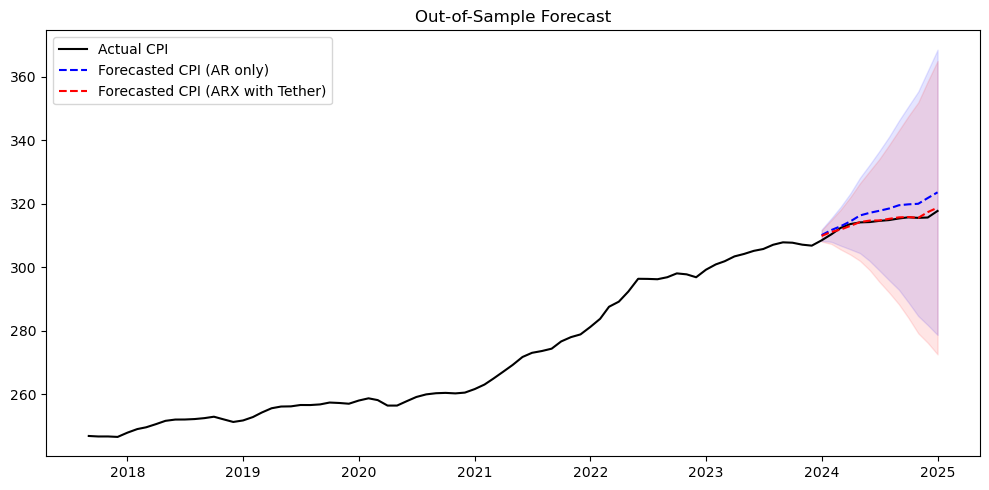

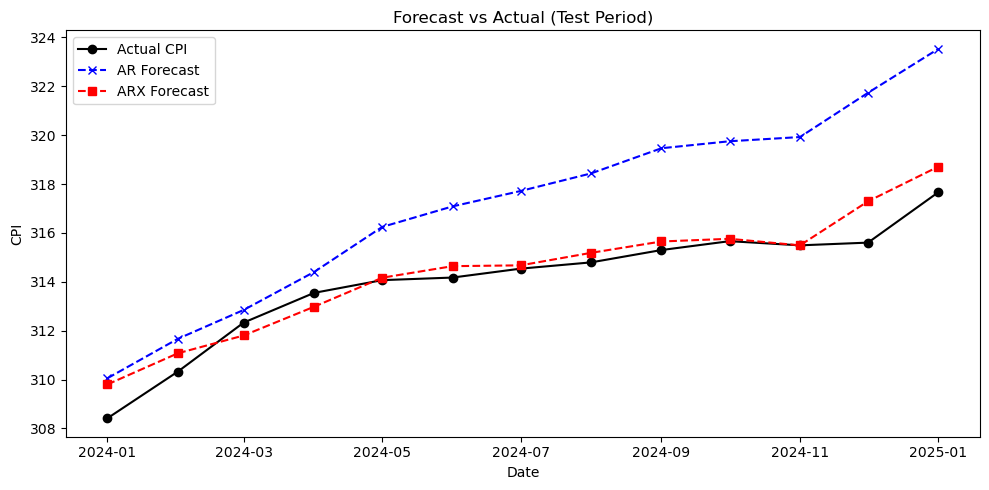

,MAE,RMSE,R2,MAPE (%),Order
Model,,,,,
AR,3.149736,3.592791,-1.351612,1.000016,"(1,2,0)"
ARX,0.577305,0.762758,0.894008,0.184185,"(1,2,0)"


In [394]:
run_model(df.copy(), 'CPI', 'Tether', plot=True)

### Combinations Where Adding Asset Data Improves the Model

In [374]:
# Reshape for comparison
df_wide = final_results.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2', 'MAPE (%)']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_MAPE'] = df_wide['MAPE (%)_ARX'] < df_wide['MAPE (%)_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_MAPE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics (MAE, RMSE, MAPE, R²):")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'MAPE (%)_AR', 'MAPE (%)_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")


# Partial wins
print("\n Combinations where ARX has lower MAE:")
display(df_wide[df_wide['ARX_better_MAE']][['Macro', 'Asset', 'MAE_AR', 'MAE_ARX']])

print("\n Combinations where ARX has lower RMSE:")
display(df_wide[df_wide['ARX_better_RMSE']][['Macro', 'Asset', 'RMSE_AR', 'RMSE_ARX']])

print("\n Combinations where ARX has lower MAPE:")
display(df_wide[df_wide['ARX_better_MAPE']][['Macro', 'Asset', 'MAPE (%)_AR', 'MAPE (%)_ARX']])

print("\n Combinations where ARX has higher R²:")
display(df_wide[df_wide['ARX_better_R2']][['Macro', 'Asset', 'R2_AR', 'R2_ARX']])

Combinations where ARX (with asset) outperforms AR on all metrics (MAE, RMSE, MAPE, R²):


,Macro,Asset,MAE_AR,MAE_ARX,RMSE_AR,RMSE_ARX,MAPE (%)_AR,MAPE (%)_ARX,R2_AR,R2_ARX
0,CC,Tether,2.526753,2.519035,3.438489,3.437075,3.396513,3.392602,0.339948,0.340491
2,CPI,Tether,3.149736,0.577305,3.592791,0.762758,1.000016,0.184185,-1.351612,0.894008
4,GDP Monthly,Tether,119.339310,76.415405,126.999847,91.952061,0.511925,0.328238,0.567334,0.773186
8,MOVE,Tether,34.699947,34.352207,37.926242,37.654335,35.870447,35.545239,-9.176955,-9.031554
10,PC2_macro,Tether,98.854498,58.296903,106.911753,75.794138,0.481666,0.283626,0.728595,0.863593



 Combinations where ARX has lower MAE:


,Macro,Asset,MAE_AR,MAE_ARX
0,CC,Tether,2.526753,2.519035
2,CPI,Tether,3.149736,0.577305
4,GDP Monthly,Tether,119.339310,76.415405
8,MOVE,Tether,34.699947,34.352207
10,PC2_macro,Tether,98.854498,58.296903



 Combinations where ARX has lower RMSE:


,Macro,Asset,RMSE_AR,RMSE_ARX
0,CC,Tether,3.438489,3.437075
2,CPI,Tether,3.592791,0.762758
4,GDP Monthly,Tether,126.999847,91.952061
8,MOVE,Tether,37.926242,37.654335
10,PC2_macro,Tether,106.911753,75.794138
12,r,Tether,0.387541,0.278175



 Combinations where ARX has lower MAPE:


,Macro,Asset,MAPE (%)_AR,MAPE (%)_ARX
0,CC,Tether,3.396513,3.392602
2,CPI,Tether,1.000016,0.184185
4,GDP Monthly,Tether,0.511925,0.328238
8,MOVE,Tether,35.870447,35.545239
10,PC2_macro,Tether,0.481666,0.283626
12,r,Tether,5.038391,4.558171



 Combinations where ARX has higher R²:


,Macro,Asset,R2_AR,R2_ARX
0,CC,Tether,0.339948,0.340491
2,CPI,Tether,-1.351612,0.894008
4,GDP Monthly,Tether,0.567334,0.773186
8,MOVE,Tether,-9.176955,-9.031554
10,PC2_macro,Tether,0.728595,0.863593
12,r,Tether,-0.161412,0.401606


## Testing Individual Combinations

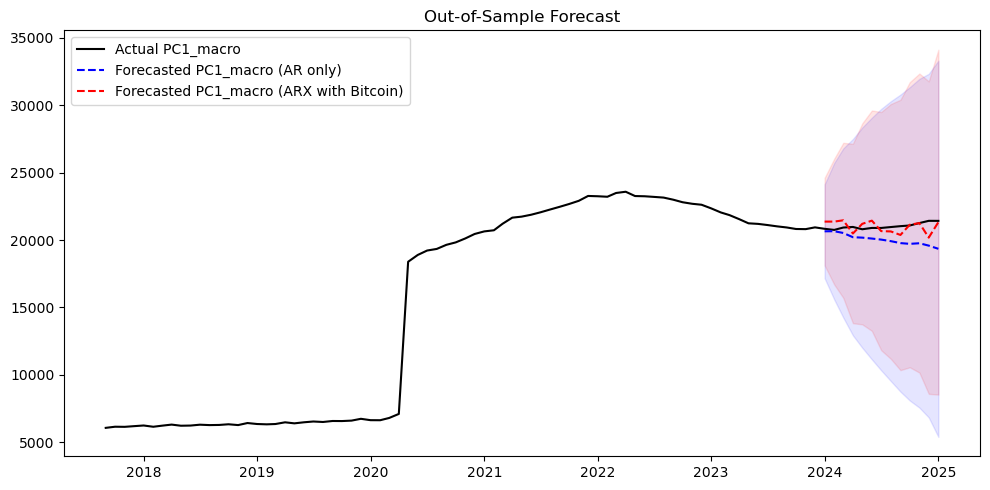

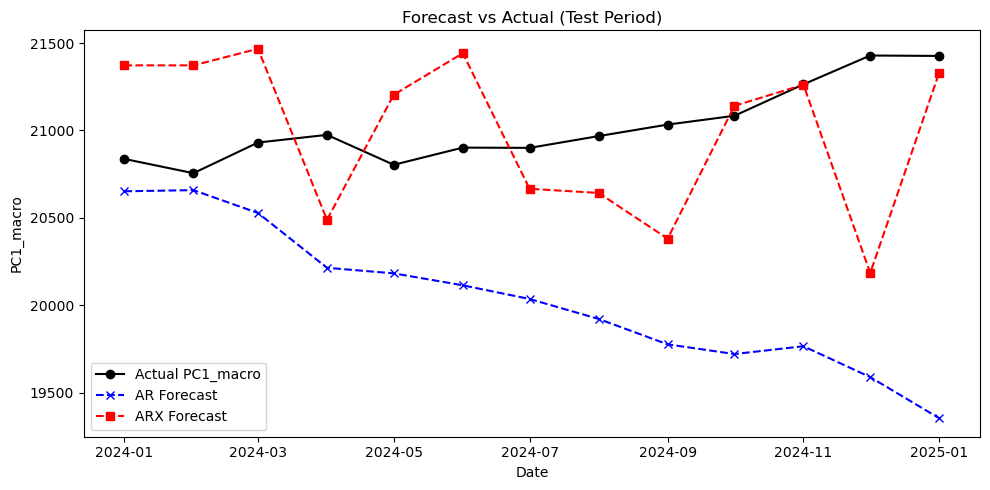

,MAE,RMSE,R2,MAPE (%),Order
Model,,,,,
AR,984.237581,1143.344565,-27.964347,4.656080,"(1,1,0)"
ARX,440.314073,539.858263,-5.457568,2.094401,"(1,1,0)"


In [375]:
macro = 'PC1_macro'
asset = 'Bitcoin'
run_model(df.copy(), macro, asset, plot=True)

## Finding Optimal Crypto Lag

In [376]:
# def find_optimal_lag(df, macro, asset, max_lag=6, verbose=False):
#     best_lag = None
#     best_improvement = np.inf
#     best_metrics = None

#     results = []

#     for lag in range(0, max_lag + 1):
#         # Temporarily override lag

#         try:
#             metrics = run_model(df, macro, asset, lag, plot=False)
#             ar = metrics.loc['AR']
#             arx = metrics.loc['ARX']

#             delta_mape = arx['MAPE (%)'] - ar['MAPE (%)']
#             results.append({
#                 'Lag': lag,
#                 'ΔMAPE': delta_mape,
#             })

#             if delta_mape < best_improvement:
#                 best_lag = lag
#                 best_improvement = delta_mape
#                 best_metrics = metrics

#             if verbose:
#                 print(f"Lag {lag}: ΔMAPE = {delta_mape:.2f}")

#         except Exception as e:
#             print(f"Lag {lag}: Failed with error: {e}")
#             continue

#     results_df = pd.DataFrame(results)
#     return best_lag, best_improvement, results_df, best_metrics


In [377]:
# for macro in ar_orders.keys():
#     best_lag, _, _, _ = find_optimal_lag(df, macro, asset="PC2_crypto", max_lag=6)
    
#     if best_lag is not None:
#         ar_orders[macro]["PC2_crypto_lag"] = best_lag
#     else:
#         ar_orders[macro]["PC2_crypto_lag"] = np.nan 